In [1]:
import calendar
from datetime import datetime as pydt
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns

plt.style.use('seaborn-dark')

In [2]:
url = "https://api.midway.tomtom.com/ranking/liveHourly/ITA_rome"

In [3]:
# Request the data as json
url_req = requests.get(url)
url_json = url_req.json()

In [4]:
# Create a pandas dataframe from the json
traffic_data = pd.DataFrame(columns=["UpdateTime", "TrafficIndexLive"])
for row in url_json["data"]:
    traffic_data = traffic_data.append({"UpdateTime": row["UpdateTime"], 
                                        "TrafficIndexLive": row["TrafficIndexLive"]}, 
                                       ignore_index=True)
traffic_data['UpdateTime'] =  pd.to_datetime(traffic_data['UpdateTime'], unit="ms")
traffic_data['TrafficIndexLive'] =  traffic_data['TrafficIndexLive'].astype(int)

In [5]:
# Resample 1H
traffic_data = traffic_data.resample('1H', on='UpdateTime')["TrafficIndexLive"].mean().reset_index()

In [6]:
# Get hour and day
traffic_data["hour"] = traffic_data['UpdateTime'].dt.strftime('%H:00')
traffic_data["day"] = traffic_data['UpdateTime'].dt.strftime('%x')

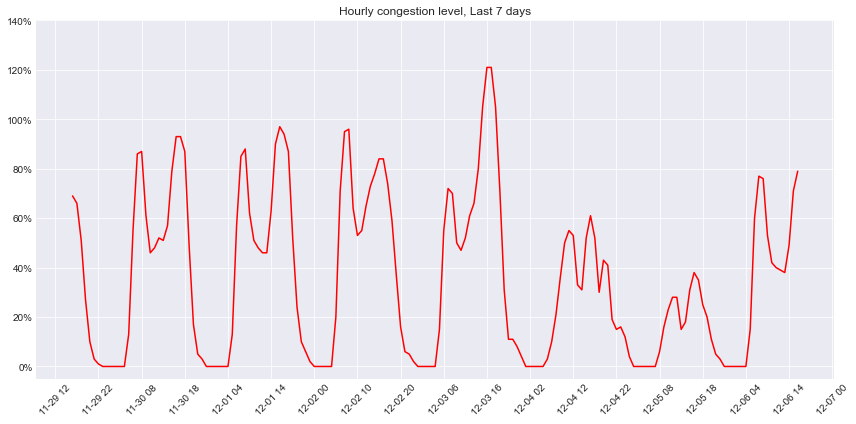

In [7]:
# Creates a figure and one subplot
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Hourly congestion level, Last 7 days")
ax.plot(traffic_data['UpdateTime'], traffic_data['TrafficIndexLive'], color="r")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_locator(mdates.HourLocator(interval=10))
plt.xticks(rotation=45)
ax.set_ylim(-5, 140)
ax.grid(True)
# Show the plot
plt.tight_layout()
plt.show()

In [8]:
# Group by day, hour
traffic_data_hm = traffic_data.groupby(["day", "hour"])["TrafficIndexLive"].mean().reset_index()

In [9]:
# Create the 7 days heatmap
days = [pydt.strptime(date, "%x") for date in traffic_data_hm["day"].unique()]
month_day = ["{}, {}".format(calendar.month_name[date.month], 
                                date.day) for date in days]
heatmap_pt = pd.pivot_table(traffic_data_hm, 
                            values="TrafficIndexLive", 
                            index=["hour"], 
                            columns="day")

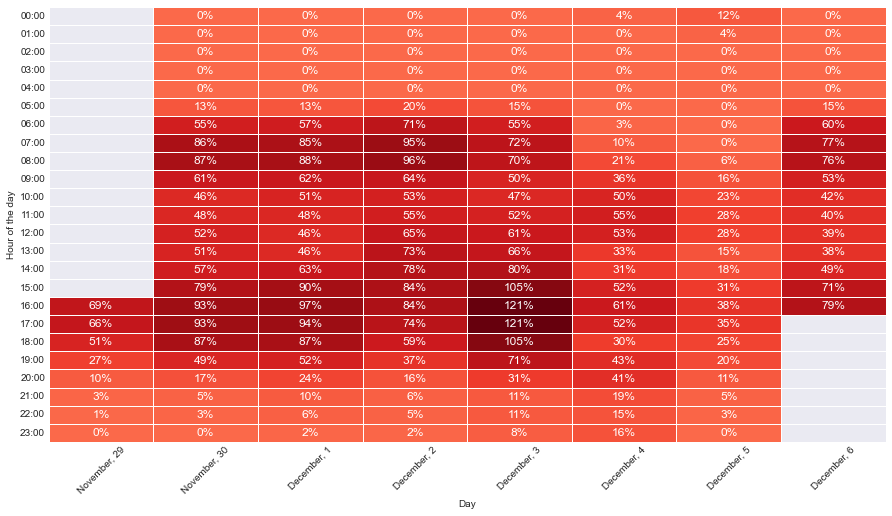

In [10]:
# Plot the heatmap
fig, ax = plt.subplots(figsize=(15,8))
sns.set()
ax = sns.heatmap(heatmap_pt/100, cmap="Reds", 
                 center=0.00, 
                 annot=True, 
                 fmt='.0%', 
                 linewidth=.5, 
                 cbar=False)
ax.set_xlabel("Day")
ax.set_ylabel("Hour of the day")
ax.set_xticklabels(month_day)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()